**SOW-MKI49: Neural Information Processing Systems**  
*Weeks 2 and 3: Assignment (200 points + 20 bonus points + 1 bonus point for each bug you find and another bonus point if you debug it and before you ask, no, typos unfortunately are not considered bugs - first come, first served)*  
Author: Umut

In [ ]:
# Group number: 6
# Student 1 name, student 1 number: Aumkar Lele, s4743962
# Student 2 name, student 2 number: Djamari Oetringer, s4464559
# Student 3 name, student 3 number: Daphne Lenders, s4433556

**Packages (10 points)**  
In this cell, you will import the required packages.  
*Tasks*   
- (1) It is always good practice to first think about the big picture and not rush into writing code before clearly knowing everything that you will have to do so as to avoid future complications. Therefore, your first task is to study the skeleton code and come up with a plan of how to proceed. (**0 points**)
- (2) However, I agree that doing so is arguably the most boring part of coding, and you rather skip it. To help you to resist the temptation of skipping going through the skeleton code, I have removed the import statements. Your second task is to Identify the required packages and import them. Note that if you are using Python 2.7, you should import print from the future. (**10 points**)

In [1]:
import os
import numpy as np
import chainer.functions as F
import chainer.links as L
import chainer
import cv2
import matplotlib.pyplot as plt
import cupy as cp
from chainer.serializers import load_npz, save_npz
from chainer.optimizers import Adam
from chainer import ChainList, Chain, iterators
from skimage.measure import compare_psnr, compare_ssim
from chainer.dataset import concat_examples, DatasetMixin
from glob import glob
from PIL import Image

In [2]:
batch_size = 16
batch_test = 4
root_dir = os.path.normpath(os.path.join(os.path.dirname(os.path.realpath('__file__'))))
data_directory = os.path.join(root_dir, 'lfw-deepfunneled') # Make a directory to store the data and enter it here.
                    # We will be using a smaller dataset (LFW) than the one used in the paper (CelebA) for computational resource considerations.
                    # Download it from http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz.
resize_dir = os.path.join(root_dir, 'Resized_images')
device = -1
epochs = 5
lambda_ = {'feature': 1., 'pixel': 1., 'total_variation': 1e-5}
model_directory = os.path.join(root_dir, 'NIPS_model_ass1') # Make a directory to store the models and enter it here. Move Vgg4Layers.npz to the model directory.
outsize = (96, 96)

**Preprocessing functions (10 points + 5 bonus points)** (taken from https://github.com/mbeyeler/opencv-python-blueprints)  
In the following cell, you will implement some of the preprocessing functions. The rest of the preprocessing steps have already been applied to the data.  
*Tasks*
- (1) Implement the resizing operation. That is, you should extract the data, resize each portrait to 96 pixels x 96 pixels and save them to the data directory as JPG. (**10 points **)
- (2) The pencil sketch class implements the sketch effect in a simpler way than the one mentioned in the lecture. Explain how/why the used operations (blur and divide) convert portraits to sketches, and how it differs from that which was mentioned in the lecture? (**5 bonus points**)

In [ ]:
# (1) Resizing and saving each portrait in the data directory

iterator = 0

for root, dirs, files in os.walk(data_directory):
    for fname in files:

        filepath = os.path.join(root, fname)
        
        img = cv2.imread(filepath)
        
        img1 = cv2.resize(img, (96, 96))
        
        cv2.imwrite(os.path.join(resize_dir, '%r_1.jpg' %iterator), img1)
        
        iterator += 1

In [3]:
class PencilSketch:
    """Pencil sketch effect
        A class that applies a pencil sketch effect to an image.
    """

    def __init__(self, dimension):
        """Initialize parameters
            :param (width, height): Image size.
        """
        self.width, self.height = dimension
        '''self.canvas = cv2.imread(self, cv2.CV_8UC1)
        
        if self.canvas is not None:
            self.canvas = cv2.resize(self.canvas, (self.width, self.height))'''

    def render(self, img_rgb):
        """Applies pencil sketch effect to an RGB image
            :param img_rgb: RGB image to be processed
            :returns: Processed RGB image
        """
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        img_blur = cv2.GaussianBlur(img_gray, (21, 21), 0, 0)
        img_blend = cv2.divide(img_gray, img_blur, scale=256)
        
        return img_blend

def pencil_sketch(img_rgb):
    pencilSketch = PencilSketch((img_rgb.shape[1], img_rgb.shape[0]))

    return pencilSketch.render(img_rgb)

# (2) Write your answer here.
'''
In the original paper, the following steps were taken:
1) Convert the original image to a grayscale image. -> Let's cal this image 'gray'
2) Invert the grayscale image, which gives a negative image. -> gray^(-1)
3) Apply Gaussian blur. -> blurred(gray^(-1)))
4) Blend resulting image with the grayscale version (1) using color dodge. -> colorDodge(gray, blurred(gray^(-1))

Here, we the following steps are taken:
1) Convert the original image to a grayscale image. –> gray
2) Apply Gaussian blur. -> blurred(gray) 
3) Pixel-wise divide the grayscale image (1) by the Gaussian blurred image (2). -> gray/blurred(gray)

colorDodge actually works by dividing one input by the inverted other input. 
Thus, the paper inverts an image twice, which brings us back to a non-inverted image. 
Then it divides these two non-inverted images, which is exactly what happens in step 3 in this code.
Conclusion: the steps of the paper and the steps of the code here are mathematically the same.
colorDodge(gray, blurred(gray^(-1)) = gray/blurred(gray).
''' 

def preprocess(img):
    if img.mode == 'L':
        return np.rollaxis(np.asarray(img, 'float32')[..., None], 2)
    else:
        return np.rollaxis(np.asarray(img, 'float32')[..., ::-1], 2)

**Data class**  
The following cell defines the data class. It is used to manage the data (loading, etc.). *You do not have to make any changes to the code.*  
*Task*
- (1) Study the code and refer to the chainer docuimentation if anything is unclear. You will be expected to write similar code by yourself in the coming practicals. (**0 points**)

In [4]:
class Dataset(DatasetMixin):
    def __init__(self, data_files):
        self.data_files = data_files

    def __len__(self):
        return len(self.data_files)

    def get_example(self, i):
        t = np.asarray(Image.open(self.data_files[i]).convert('RGB').resize((96, 96), Image.LANCZOS), 'f').transpose(2, 0, 1)
        x = pencil_sketch(np.asarray(Image.open(self.data_files[i]).convert('RGB').resize((96, 96), Image.LANCZOS), 'f'))[None]

        if device < 0:
            return t, x
        else:
            return cp.asarray(t), cp.asarray(x)

**Model classes (45 points)**  
In the following cellyou will implement the model classes.
*Tasks*   
- (1) Implement the layers of the model by filling in the missing code. (**20 points**)
- (2) Reimplement the model as a ChainList instead of a Chain. (**5 points**)
- (3) Implement the forward pass of the residual block by filling in the missing code. (**20 points**)

In [5]:
class Model(Chain):
    def __init__(self, in_channels, outsize):
        super(Model, self).__init__()
        
        with self.init_scope():
            # (1) start
            self.convolution2D_0 = L.Convolution2D(1, 32, 9, 1, 4, True)
            self.batchNormalization_0 = L.BatchNormalization(32)
            self.convolution2D_1 = L.Convolution2D(32, 64, 3, 2, 1, True)
            self.batchNormalization_1 = L.BatchNormalization(64)
            self.convolution2D_2 = L.Convolution2D(64, 128, 3, 2, 1, True)
            self.batchNormalization_2 = L.BatchNormalization(128)
            self.residualBlock_3 = ResidualBlock(128, 128)
            self.residualBlock_4 = ResidualBlock(128, 128)
            self.residualBlock_5 = ResidualBlock(128, 128)
            self.residualBlock_6 = ResidualBlock(128, 128) 
            self.residualBlock_7 = ResidualBlock(128, 128)
            self.deconvolution2D_8 = L.Deconvolution2D(128, 64, 3, 2, 1, True, outsize = (48, 48))
            self.batchNormalization_8 = L.BatchNormalization(64)
            # (1) end
            self.deconvolution2D_9 = L.Deconvolution2D(64, 32, 3, 2, 1, True, outsize)
            self.batchNormalization_9 = L.BatchNormalization(32)
            self.convolution2D_10 = L.Convolution2D(32, 3, 9, pad = 4, nobias = True)
            self.batchNormalization_10 = L.BatchNormalization(3)

        self.in_channels = in_channels
        self.outsize = outsize

    def __call__(self, x, finetune = False):
        h = self.convolution2D_0(x)
        h = self.batchNormalization_0(h, finetune = False)
        h = F.relu(h)
        h = self.convolution2D_1(h)
        h = self.batchNormalization_1(h, finetune = False)
        h = F.relu(h)
        h = self.convolution2D_2(h)
        h = self.batchNormalization_2(h, finetune = False)
        h = F.relu(h)
        h = self.residualBlock_3(h, finetune = False)
        h = self.residualBlock_4(h, finetune = False)
        h = self.residualBlock_5(h, finetune = False)
        h = self.residualBlock_6(h, finetune = False)
        h = self.residualBlock_7(h, finetune = False)
        h = self.deconvolution2D_8(h)
        h = self.batchNormalization_8(h, finetune = False)
        h = F.relu(h)
        h = self.deconvolution2D_9(h)
        h = self.batchNormalization_9(h, finetune = False)
        h = F.relu(h)
        h = self.convolution2D_10(h)
        h = self.batchNormalization_10(h, finetune = False)
        y = 127.5 * F.tanh(h) + 127.5

        return y

class Model(ChainList):
    # (2) start
    def __init__(self, in_channels, outsize):
        with self.init_scope():
            links=[L.Convolution2D(1, 32, 9, 1, 4, True)]
            links.append(L.BatchNormalization(32))
            links.append(L.Convolution2D(32, 64, 3, 2, 1, True))
            links.append(L.BatchNormalization(64))
            links.append(L.Convolution2D(64, 128, 3, 2, 1, True))
            links.append(L.BatchNormalization(128))
            links.append(ResidualBlock(128, 128))
            links.append(ResidualBlock(128, 128))
            links.append(ResidualBlock(128, 128))
            links.append(ResidualBlock(128, 128))
            links.append(ResidualBlock(128, 128))
            links.append(L.Deconvolution2D(128, 64, 3, 2, 1, True, outsize = (48, 48)))
            links.append(L.BatchNormalization(64))
            links.append(L.Deconvolution2D(64, 32, 3, 2, 1, True, outsize))
            links.append(L.BatchNormalization(32))
            links.append(L.Convolution2D(32, 3, 9, pad = 4, nobias = True))
            links.append(L.BatchNormalization(3))
            
            super(Model, self).__init__(*links)
            
        self.in_channels = in_channels
        self.outsize = outsize
            
    def __call__(self, x, finetune = False):
        h = self[0](x)
        h = self[1](h)
        h = self[2](F.relu(h))
        h = self[3](h)
        h = self[4](F.relu(h))
        h = self[5](h)
        h = self[6](F.relu(h))
        h = self[7](h)
        h = self[8](h)
        h = self[9](h)
        h = self[10](h)
        h = self[11](h)
        h = self[12](h)
        h = self[13](F.relu(h))
        h = self[14](h)
        h = self[15](F.relu(h))
        h = self[16](h)
        y = 127.5 * F.tanh(h) + 127.5

        return y
    # (2) end 

class ResidualBlock(Chain):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        with self.init_scope():
            
            self.batchNormalization_0 = L.BatchNormalization(out_channels)
            self.batchNormalization_1 = L.BatchNormalization(out_channels)
            self.convolution2D_0 = L.Convolution2D( in_channels, out_channels, 3, pad = 1, nobias = True)
            self.convolution2D_1 = L.Convolution2D(out_channels, out_channels, 3, pad = 1, nobias = True)

        self.in_channels = in_channels
        self.out_channels = out_channels

    def __call__(self, x, finetune = False):
        # (3) start
        h = self.convolution2D_0(x)
        h = self.batchNormalization_0(h, finetune = False)
        h = F.relu(h)
        h = self.convolution2D_1(h)
        h = self.batchNormalization_1(h, finetune = False)
        y = F.relu(h)
        h = h + x
        # (3) end

        return y

**Loss classes (45 points)**  
In the following cell, you will implement the loss classes.  
*Tasks*  
- (1) You are provided with a custom VGG-16 implementation. How does it differ than the original implementation? Why can we get away with using the simpler implementation? (**5 points**)
- (2) Implement the missing convolution layer of the total variation loss by filling in the missing code. (**10 points**)
- (3) Implement the forward pass of the total variation loss by filling in the missing code. (**10 points**)
- (4) Implement the feature loss component in the forward pass of the loss function by filling in the missing code. (**10 points**)
- (5) Explain why the loss components are scaled. (**5 points**)
- (6) Explain why the target features are extracted in test mode. (**5 points**)

In [6]:
class Vgg4Layers(Chain):
    def __init__(self):
        super(Vgg4Layers, self).__init__()

        with self.init_scope():
            self.convolution2D_0 = L.Convolution2D(  3,  64, 3, pad = 1)
            self.convolution2D_1 = L.Convolution2D( 64,  64, 3, pad = 1)
            self.convolution2D_2 = L.Convolution2D( 64, 128, 3, pad = 1)
            self.convolution2D_3 = L.Convolution2D(128, 128, 3, pad = 1)


    def __call__(self, x):
        #x = cupy.asnumpy(x)
        
        h = x - F.broadcast_to(self.mean, x.shape)
        h = self.convolution2D_0(h)
        h = F.relu(h)
        h = self.convolution2D_1(h)
        h = F.relu(h)
        h = F.max_pooling_2d(h, 2, 2)
        h = self.convolution2D_2(h)
        h = F.relu(h)
        h = self.convolution2D_3(h)
        y = F.relu(h)

        return y

class TotalVariationLoss(Chain):
    def __init__(self):
        super(TotalVariationLoss, self).__init__()

        with self.init_scope():
          
            self.convolution2D_0 = L.Convolution2D(3, 1, 2, nobias = True, initialW  = np.array([3 * [[[-1], [1]]]])) 
            # (2) start
            self.convolution2D_1 = L.Convolution2D(3, 1, 2, nobias = True, initialW = np.array([3 * [[[1], [-1]]]]))
            # (2) end
            

    def __call__(self, x):
        # (3) start
        y = F.sum(F.sqrt(F.square(self.convolution2D_0(x)) + F.square(self.convolution2D_1(x))))
        return y
        # (3) end




class LossFunction(object):
    def __init__(self, lambda_):
        if device < 0:
            self.totalVariationLoss = TotalVariationLoss()
            self.vgg4Layers = Vgg4Layers()
            
        else:
            self.totalVariationLoss = TotalVariationLoss().to_gpu(device)
            self.vgg4Layers = Vgg4Layers().to_gpu(device)
            

    def __call__(self, t, y):            
        with chainer.using_config('train', False):
            t_ = self.vgg4Layers(t)

        # (4) start
            y_ = self.vgg4Layers(y)
        feature_loss = lambda_['feature'] * F.mean_squared_error(t_, y_)
        # (4) end
        pixel_loss = lambda_['pixel'] * F.mean_squared_error(t, y)
        total_variation_loss = lambda_['total_variation'] * self.totalVariationLoss(y)
        loss = feature_loss + pixel_loss + total_variation_loss

        return loss

# (1)

'''
VGG-16 is a 16 layer deep CNN used for classifying images in the ImageNet challenge. However not all 16 layers
are used in this implementation but only the first 4 layers. By extracting only the pre-trained weights of the 
first 4 layers, the layers containing information about low level features (such as edges and lines) are obtained. 
Since the detection of these low-level features is mostly task independent (i.e. they don't depend on the images the network
was trained on) the already trained layers can interchangebly be used for different problem domains: Thus even though VGG-16
was build to classify ImageNet images, the features of the first layers can be helpful for the task of sketch inversion as well. 
By not having to train a network to detect low level features, computation power and time can be saved. 
The technique is commonly referred to as transfer learning. 
'''

# (5) 
'''
In the original paper it was observed that the combination of pixel and feature loss increase the image quality of the output
pictures. Using feature loss however also introduces some artefacts to the image which can be resolved by adding a small
proportion of total variation loss to the loss function. Since only a small proportion was found to resolve the issue, the 
total variation loss needs to be scaled down.
Adding the whole total variation loss might come at a price of the picture's quality since important details of the picture
might get lost: Total variation loss aims to minimize the difference between the intensity of neighbouring pixels, however 
minimizing this intensity too much might result in a picture where clear outlines are not recognizable anymore. 
'''

# (6)
'''
The weights of the VGG layer should be frozen at all times and should not be re-trained and hence the 'train' configuration 
is set to false.
'''

"\nThe weights of the VGG layer should be frozen at all times and should not be re-trained and hence the 'train' configuration \nis set to false.\n"

**Initialization (10 points)**  
The following cell initializes the loss function, the loss history, the model, the optimizer, the datasets and the iterators. *You do not have to make any changes to the code.*  
*Tasks*
- (1) Study the code and refer to the chainer docuimentation if anything is unclear. You will be expected to write similar code by yourself in the coming practicals. (**0 points**)  
- (2) What are the boolean arguments that are passed to the SerialIterator class? (**5 points**)  
- (3) Why is it false for the training iterator but not for other iterators? In other words, what would happen if we were to set it to false for the training iterator and true for the other iterators? (**5 points**)

In [33]:
lossFunction = LossFunction(lambda_)
load_npz('{:s}/Vgg4Layers.npz'.format(model_directory), lossFunction.vgg4Layers, strict = False)
lossFunction.vgg4Layers.add_persistent('mean', np.array([[[[103.939]], [[116.779]], [[123.68]]]], 'float32'))
loss_history = {'training': [], 'validation': []}
model = Model(3, outsize) if device < 0 else Model(3, outsize).to_gpu(device)
optimizer = Adam(alpha=1e-5, beta1=0.9, beta2=0.999, eps=1e-09)

optimizer.setup(model)

data_file = sorted(glob('{}/*.jpg'.format(resize_dir)))
training_set = Dataset(data_file[:int(.64 * len(data_file))])
validation_set = Dataset(data_file[int(.64 * len(data_file)) : int(.8 * len(data_file))])
test_set = Dataset(data_file[int(.8 * len(data_file) ):])
training_iterator = iterators.SerialIterator(training_set, batch_size, False, True)
validation_iterator = iterators.SerialIterator(validation_set , batch_size, False, False)
test_iterator = iterators.SerialIterator(test_set, batch_test, False, False)


# (2)
'''
The first boolean value is Repeat, the second is Shuffle.
- Repeat: if Repeat is False (which is always the case here), the iteration is stopped after 
going through the whole list once. If Repeat if True (which is never the case here), the iterator 
loops infintely.
- Shuffle: if Shuffle is True, the order of the elements in the given set is randomized at the 
start of each epoch. If Shuffle is false, the given order is used.
'''

# (3)
'''
In case of the training iterator, Shuffle is set to True. This is because the given training_set 
has an order that is based on the alphabetical order per person. Thus, the iterator will first 
look at all examples of one person, than another, etc. As a consequence, the same person is shown 
to the model while training, which could make the model biased towards the faces it saw at the 
start of the training. I.e., a different order of the input images results in a differently trained 
model. The input images have to be randomized. If not, the model could fail to generalize and thus 
the performance during testing and validation will be low.
In case of testing and validation, the order of the images does not matter anymore, since the weights 
have already been trained.
'''

'\nIn case of the training iterator, Shuffle is set to True. This is because the given training_set \nhas an order that is based on the alphabetical order per person. Thus, the iterator will first \nlook at all examples of one person, than another, etc. As a consequence, the same person is shown \nto the model while training, which could make the model biased towards the faces it saw at the \nstart of the training. I.e., a different order of the input images results in a differently trained \nmodel. The input images have to be randomized. If not, the model could fail to generalize and thus \nthe performance during testing and validation will be low.\nIn case of testing and validation, the order of the images does not matter anymore, since the weights \nhave already been trained.\n'

**Training and validation (20 points)**  
In the following cell, you will train and validate your model.
*Tasks*   
- (1) Implement training loss estimation, backprop and parameter update. (**10 points**)
- (2) Implement validation loss history (**5 points**)
- (3) Implement model serialization  (**5 points**)

In [ ]:
model.cleargrads()

for i in range(epochs):
    loss_history['training'].append(0)
    print('Epoch: ', i)
    training_iterator = iterators.SerialIterator(training_set, batch_size, False, True)
    for j, batch in enumerate(training_iterator):
        print('Iteration number: ', j)
        with chainer.using_config('train', True):
            t, x = concat_examples(batch)
            y = model(x)
            
            # (1) start
            loss = lossFunction(t, y)
            loss.backward()
            optimizer.update()
            model.cleargrads()
            # (1) end
            loss_history['training'][-1] += float(loss.data)

    loss_history['training'][-1] /= (j + 1)
    
    # (2) start
    loss_history['validation'].append(0)
    validation_iterator = iterators.SerialIterator(validation_set , batch_size, False, False)
    for j, batch in enumerate(validation_iterator):
        with chainer.using_config('train', False):
            t, x = concat_examples(batch)
            y_val = model(x)
            loss = lossFunction(t, y_val)
            loss_history['validation'][-1] += float(loss.data)

    loss_history['validation'][-1] /= (j + 1)
    # (2) end
    
    print('epoch: {:3d} / {:03d}, training loss: {:.4f}, validation loss: {:.4f}.'.format(i + 1, epochs, loss_history['training'][i], loss_history['validation'][i]))
    np.savez('{:s}/loss_history_{:03d}.npz'.format(model_directory, i + 1), loss_history)
    # (3) start
    save_npz('{:s}/model_{:03d}.npz'.format(model_directory, i + 1), model)
    # (3) end
    save_npz('{:s}/optimizer_{:03d}.npz'.format(model_directory, i + 1), optimizer)

**Test (45 points + 15 bonus points)**  
In the following cell, you will test your model.  
*Tasks*
- (1) Estimate the test loss, print it and save it. (**15 points**)
- (2) Estimate the validation metrics, print them and save them (tip: scikit-image) (**15 bonus points**)
- (3) Plot example results (i.e., plot a few t, x and y) (**10 points**)
- (4) Dicuss your implementation in 300 - 350 words (e.g., how good your results are, how you can improve your model, etc.) (**20 points**)

In [8]:
model = load_npz(os.path.join(model_directory, 'model_005.npz'), lossFunction.vgg4Layers, strict = False)

25950.925248579544


"\nThe model was trained on a very small data set with 138 images on a CPU machine. Due to a very small training set, the model was\nharder to train and hence a very low learning rate of 1e-5 was used. The model converges after 6th epoch as can be seen from the\ntraining process where the loss goes to 'nan' after the 6th epoch. \n"

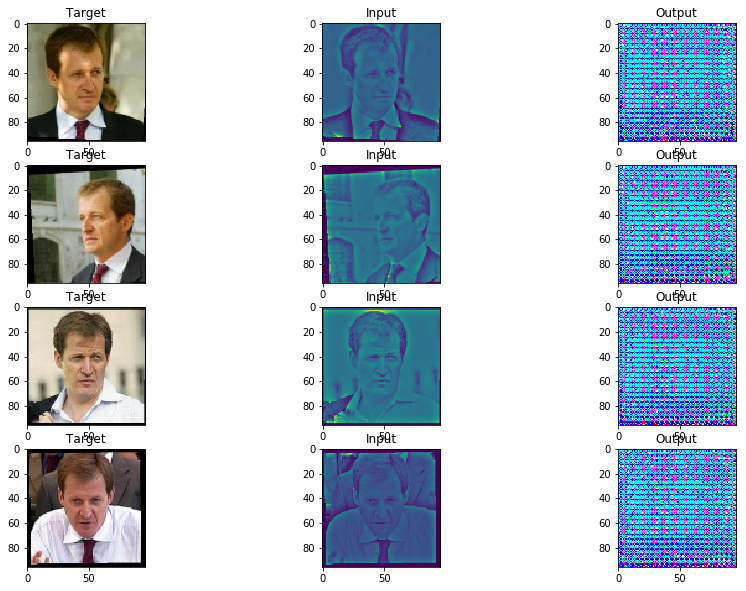

In [34]:
# (1), (2) and (3) start

# (1) and (3)

first_batch = True
test_loss = []
for j, batch in enumerate(test_iterator):
    with chainer.using_config('train', False):
        t, x = concat_examples(batch)
        y_test = model(x)
        y_ = y_test.array
        loss = lossFunction(t, y_test)
        if first_batch:
            fig, subplots = plt.subplots(4, 3, figsize = (15, 10))
            for image in (range(y_test.shape[0])):
                t_ = t[image].transpose(1, 2, 0)
                x_ = x[image].transpose(1, 2, 0)
                y = y_[image].transpose(1, 2, 0)
                x_flattened = x_.flatten()
                x_reshaped = x_.reshape(96, 96)

                subplots[image][0].imshow(t_/256.0)   #division by 256 because of rgb
                subplots[image][0].set_title("Target")
                subplots[image][1].imshow(x_reshaped)
                subplots[image][1].set_title("Input")
                subplots[image][2].imshow(y/256.0)
                subplots[image][2].set_title("Output")
            first_batch = False
    test_loss.append(float(loss.data))

loss = np.mean(test_loss)
      
print(loss)

# (2)
psnr = []
ssim = []
corr = []

        
'''for i, batch in enumerate(validation_iterator):
    with chainer.using_config('train', False):
        # t is target pencil sketch
        t, x = concat_examples(batch)

        y_val1 = model(x)
        y_val11 = y_val1.array

        ssim.append(compare_ssim(t, y_val11))
        psnr.append(compare_psnr(t, y_val11))
        corr.append(np.corrcoef(t, y_val11))

ssim_fin = np.mean(ssim)
psnr_fin = np.mean(psnr)
corr_fin = np.mean(corr)

print('SSIM: ', ssim_fin)
print('PSNR: ', psnr_fin)
print('CORR: ', corr_fin)'''

file = open("metrics.txt", "w")
text = "The test loss is: " + str(loss) + "\nThe average signal to noise ratio is: " + str(psnr) +  "\nThe average structural similarity is: " + str(ssim) + "\nThe correlation coefficient R is: " + str(corr)
file.write(text)
file.close()

# (1), (2) and (3) end


# (4)

'''
The implementation of the model was based on the paper provided for this assignment. Different than in the paper however 
the model was trained on a very small data set with 140 images on a CPU machine. Due to a very small training set, the 
model was harder to train and hence a very low learning rate of 1e-5 was used. In addition epsilon was reduced to 1e-9. 
The model was stopped training after the 5th epoch, since the loss took values of NaN at that point. We suspect that this
was caused by vanishing gradient problem. 
After the 5th epoch, the training loss was around 11k. The test loss was around 26k. 

The big difference between the training and test loss also indicates that the model is not generalizing
well at all and is overfitting on the training data. When looking at the target, input and output images 
only very general shapes/patterns of the original image can be recognized in the output. With more training data 
the results might have been more promising. It should be noted that the input images (the pencil sketches) 
look a bit different than expected, as they are not completely gray-scale images. Unfortunately we were not 
able to recognize which error in the code lead to this. 
It would have been interesting to see the metrices for the output-image quality, however we couldn't get the part
of SSIM, PNIR and the correlation coefficient working properly. 

As mentioned above, the model can be improved by having a larger training set and the hyper parameters can be fine tuned
further so the model generalizes better and gives accurate inverted sketches on the test set. Next to that it should 
of course be trained until it properly converges, while monitoring the validation loss.

'''